In [ ]:
import numpy as np
import pandas as pd
from time import time
from sklearn.metrics import precision_recall_curve
from torchmetrics.classification import BinaryF1Score
import torch
from torch import nn
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
import warnings
warnings.filterwarnings('ignore')

In [2]:
device = 'mps'
batch_size = 128

In [3]:
df = pd.read_csv('/Users/le_fuu/GitHub_Local/Phase_2/project_3/nlp_project/data/labeled.csv')

In [4]:
df

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0
...,...,...
14407,Вонючий совковый скот прибежал и ноет. А вот и...,1.0
14408,А кого любить? Гоблина тупорылого что-ли? Или ...,1.0
14409,"Посмотрел Утомленных солнцем 2. И оказалось, ч...",0.0
14410,КРЫМОТРЕД НАРУШАЕТ ПРАВИЛА РАЗДЕЛА Т.К В НЕМ Н...,1.0


In [5]:
# test = df['comment'].apply(lambda x: len(x.split()))
# test.describe()

In [6]:
model_checkpoint = 'cointegrated/rubert-tiny-toxicity'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint)
def text2toxicity(text, aggregate=True):
    """ Calculate toxicity of a text (if aggregate=True) or a vector of toxicity aspects (if aggregate=False)"""
    with torch.no_grad():
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True).to(model.device)
        proba = torch.sigmoid(model(**inputs).logits).cpu().numpy()
    if isinstance(text, str):
        proba = proba[0]
    if aggregate:
        return 1 - proba.T[0] * (1 - proba.T[-1])
    return proba

# print(text2toxicity('я люблю нигеров', True))
# # 0.9350118728093193

# print(text2toxicity('я люблю нигеров', False))
# # [0.9715758  0.0180863  0.0045551  0.00189755 0.9331106 ]

# print(text2toxicity(['я люблю нигеров', 'я люблю африканцев'], True))
# # [0.93501186 0.04156357]

# print(text2toxicity(['я люблю нигеров', 'я люблю африканцев'], False))
# # [[9.7157580e-01 1.8086294e-02 4.5550885e-03 1.8975559e-03 9.3311059e-01]
# #  [9.9979788e-01 1.9048342e-04 1.5297388e-04 1.7452303e-04 4.1369814e-02]]


In [7]:
def tokenize_texts(texts):
    return tokenizer(texts, padding="max_length", truncation=True, max_length=50, return_tensors="pt")

In [8]:
encodings = tokenize_texts(df["comment"].tolist())
labels = torch.tensor(df["toxic"].tolist())

In [9]:
class ToxicityDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

dataset = ToxicityDataset(encodings, labels)

In [10]:
train_ds, valid_ds = torch.utils.data.random_split(dataset, [0.8, 0.2])

train_loader = torch.utils.data.DataLoader(train_ds, shuffle=True, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(valid_ds, shuffle=True, batch_size=batch_size)

In [11]:
batch = next(iter(train_loader))
batch["input_ids"].shape, batch["labels"].shape

(torch.Size([128, 50]), torch.Size([128]))

In [12]:
class ToxicBert(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = AutoModelForSequenceClassification.from_pretrained('cointegrated/rubert-tiny-toxicity')
        for param in self.bert.parameters():
            param.requires_grad = False
        self.bert.classifier = nn.Sequential(
            nn.Linear(312, 256),
            nn.Tanh(),
            nn.Dropout(),
            nn.Linear(256, 128),
            nn.Tanh(),
            nn.Linear(128, 1)
        )
        for param in self.bert.classifier.parameters():
            param.requires_grad = True
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.logits

In [13]:
model = ToxicBert()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()
metric = BinaryF1Score().to(device)
# for params in model.parameters():
#     print(params.requires_grad)

In [14]:
def train(
        epochs: int, 
        model: torch.nn.Module, 
        train_loader: torch.utils.data.DataLoader,
        valid_loader: torch.utils.data.DataLoader, 
        optimizer: torch.optim.Optimizer, 
        criterion, 
        metric
        ) -> tuple: 
    """Training recurrent model for binary classification task

    Args:
        epochs (int): Number of epochs
        model (nn.Module): Model instance
        train_loader (Dataloader): train loader
        valid_loader (Dataloader): valid loader
        optimizer (nn.Module): optimizer
        criterion (nn.Module): criterion
        metric (_type_): metric from torchmetrics
        rnn_conf (dataclass): dataclass with params

    Returns:
        tuple: (train loss, valid loss, train metric, valid metric, training_time)
    """
    epoch_train_losses = []
    epoch_valid_losses = []
    epoch_train_metric = []
    epoch_valid_metric = []
    time_start = time()
    for epoch in range(epochs):
        batch_losses = []
        model.train()
        
        metric.reset()
        for batch in train_loader:
            input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
            labels = labels.unsqueeze(1)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)

            preds = (torch.sigmoid(outputs) > 0.5).long()  # Преобразуем в бинарные предсказания

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_losses.append(loss.item())
            metric.update(preds, labels)  # Обновляем метрику
        
        epoch_train_losses.append(np.mean(batch_losses))
        epoch_train_metric.append(metric.compute().item())  # Вычисляем финальную метрику за эпоху

        # Валидация
        batch_losses = []
        model.eval()
        metric.reset()  # Сброс метрики перед валидацией
        with torch.no_grad():
            for batch in valid_loader:
                input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
                labels = labels.unsqueeze(1)

                outputs = model(input_ids, attention_mask)
                loss = criterion(outputs, labels)

                preds = (torch.sigmoid(outputs) > 0.5).long()
                
                batch_losses.append(loss.item())
                metric.update(preds, labels)

        epoch_valid_losses.append(np.mean(batch_losses))
        epoch_valid_metric.append(metric.compute().item())

        print(f'Epoch {epoch+1}') 
        print(f'train_loss : {epoch_train_losses[-1]:.4f} val_loss : {epoch_valid_losses[-1]:.4f}')
        print(f'train_f1 : {epoch_train_metric[-1]:.2f} val_f1 : {epoch_valid_metric[-1]:.2f}')
        print(25*'==')

    training_time = time() - time_start
    return (epoch_train_losses, epoch_valid_losses, epoch_train_metric, epoch_valid_metric, training_time)

In [15]:
epoch_train_losses, epoch_valid_losses, epoch_train_metric, epoch_valid_metric, training_time = train(epochs=50, model=model, train_loader=train_loader, valid_loader=valid_loader, optimizer=optimizer, criterion=criterion, metric=metric)

Epoch 1
train_loss : 0.4055 val_loss : 0.3810
train_f1 : 0.71 val_f1 : 0.73
Epoch 2
train_loss : 0.3705 val_loss : 0.3527
train_f1 : 0.74 val_f1 : 0.80
Epoch 3
train_loss : 0.3668 val_loss : 0.3358
train_f1 : 0.75 val_f1 : 0.80
Epoch 4
train_loss : 0.3610 val_loss : 0.3372
train_f1 : 0.76 val_f1 : 0.81
Epoch 5
train_loss : 0.3626 val_loss : 0.3365
train_f1 : 0.75 val_f1 : 0.79
Epoch 6
train_loss : 0.3575 val_loss : 0.3331
train_f1 : 0.76 val_f1 : 0.80
Epoch 7
train_loss : 0.3615 val_loss : 0.3447
train_f1 : 0.76 val_f1 : 0.77
Epoch 8
train_loss : 0.3628 val_loss : 0.3352
train_f1 : 0.76 val_f1 : 0.80
Epoch 9
train_loss : 0.3565 val_loss : 0.3299
train_f1 : 0.76 val_f1 : 0.80
Epoch 10
train_loss : 0.3560 val_loss : 0.3299
train_f1 : 0.76 val_f1 : 0.81
Epoch 11
train_loss : 0.3523 val_loss : 0.3297
train_f1 : 0.77 val_f1 : 0.81
Epoch 12
train_loss : 0.3541 val_loss : 0.3285
train_f1 : 0.76 val_f1 : 0.81
Epoch 13
train_loss : 0.3523 val_loss : 0.3303
train_f1 : 0.76 val_f1 : 0.79
Epoch 14

In [21]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'petroff10',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

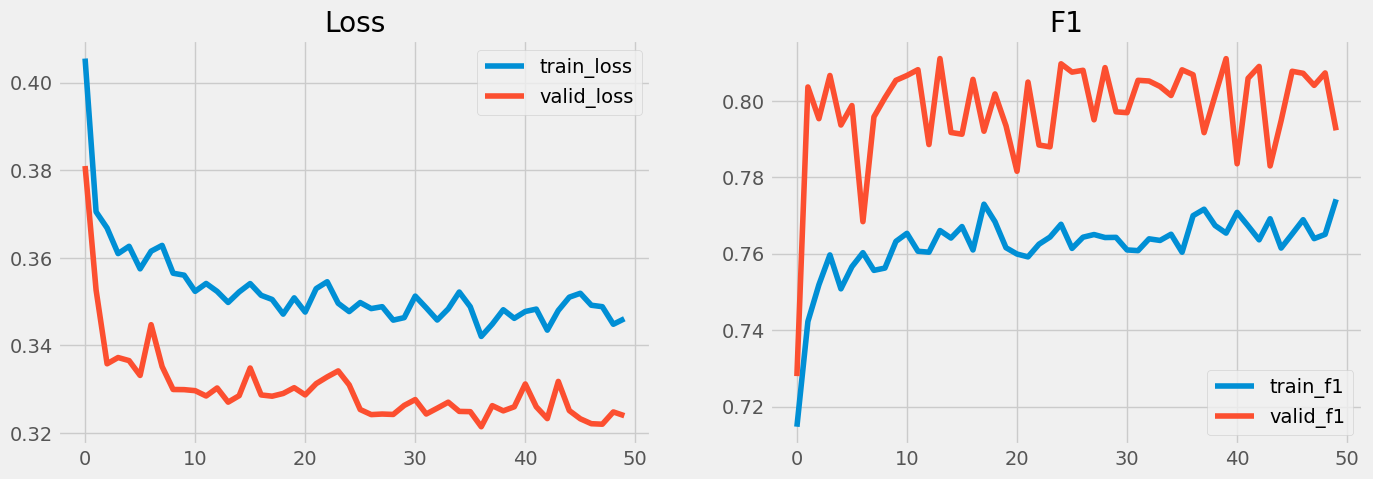

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(epoch_train_losses, label='train_loss')
ax[0].plot(epoch_valid_losses, label='valid_loss')
ax[0].legend()
ax[0].set_title('Loss')
ax[1].plot(epoch_train_metric, label='train_f1')
ax[1].plot(epoch_valid_metric, label='valid_f1')
ax[1].legend()
ax[1].set_title('F1')
plt.legend()
plt.show()
# plt.savefig('/Users/le_fuu/GitHub_Local/Phase_2/project_3/nlp_project/images/loss_f1.png')


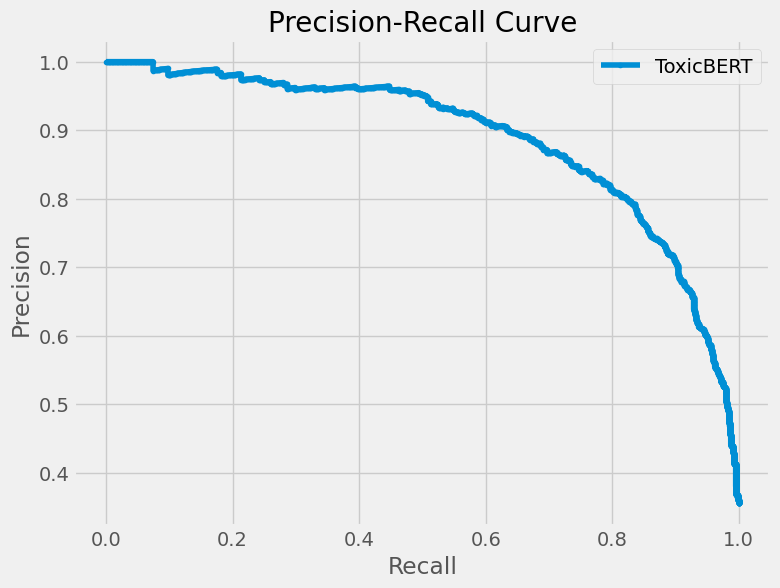

<Figure size 640x480 with 0 Axes>

In [ ]:
model.eval()
all_labels = []
all_probs = []

with torch.no_grad():
    for batch in valid_loader:
        input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
        outputs = model(input_ids, attention_mask)
        
        probs = torch.sigmoid(outputs)  # Превращаем в вероятности

        all_labels.extend(labels.cpu().numpy())  # Собираем реальные метки
        all_probs.extend(probs.cpu().numpy())    # Собираем вероятности

# Преобразовать в numpy
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# Получаем Precision-Recall
precision, recall, _ = precision_recall_curve(all_labels, all_probs)

# Построить график
plt.figure(figsize=(8,6))
plt.plot(recall, precision, marker='.', label='ToxicBERT')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()
# plt.savefig('/Users/le_fuu/GitHub_Local/Phase_2/project_3/nlp_project/images/pr_curve.png')